# Plot spatial data for 20CR

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

# HadCRUT5 infilled data

In [33]:
# open the observational dataset HadCRUT. which has 2m surface temp over land and sea water temp at a depth of 20cm
# it has monthly anomalies relative to a 1961-1990 climatology 
hadcrut5 = xr.open_dataset('HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc')
# rename lat and lon coords and select out time so same as 20CR
hadcrut5 = hadcrut5.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(time=slice('1850','1890'))
hadcrut5

<xarray.Dataset>
Dimensions:           (bnds: 2, lat: 36, lon: 72, time: 492)
Coordinates:
  * time              (time) datetime64[ns] 1850-01-16T12:00:00 ... 1890-12-1...
  * lat               (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon               (lon) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    realization       int64 ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, lat, lon) float64 ...
    time_bnds         (time, bnds) datetime64[ns] ...
    latitude_bnds     (lat, bnds) float64 ...
    longitude_bnds    (lon, bnds) float64 ...
    realization_bnds  (bnds) int64 ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.1.0 HadSST.4.0.0.0
    title:        HadCRUT.5.0.1.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.1.0
    Conventions:  CF-1.7

In [34]:
# adjust the hadcrut data to a base climatology of 1850-1880
hadcrut5_anom = func.monthly_anomaly(hadcrut5, '1850', '1880')

In [35]:
# area weighting 
hadcrut5_glob = hadcrut5_anom.tas_mean*np.cos(hadcrut5_anom.lat*(np.pi/180))
hadcrut5_glob

<xarray.DataArray (time: 492, lat: 36, lon: 72)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 1890-12-16T12:...
  * lat          (lat) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon          (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
    realization  int64 100
    month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [36]:
# Select out SH and NH anomalies 
hadcrut5_SH = hadcrut5_glob.sel(lat=slice(-90,0)) 
hadcrut5_NH = hadcrut5_glob.sel(lat=slice(0,90)) 
# select out the Australian and E Australian anomalies 
hadcrut5_Aus = hadcrut5_glob.sel(lat=slice(-50,-10), lon=slice(110,160))#.where(landmask.LAND==1.0, drop=True)
hadcrut5_EA = hadcrut5_glob.sel(lat=slice(-50,-10), lon=slice(140,155))#.where(landmask.LAND==1.0, drop=True)

## Figures

In [37]:
# eruption dates
e_date = ['1883-08','1902-10', '1963-03', '1982-04', '1991-06']
e_post6mon = ['1884-02', '1903-04', '1963-09', '1982-10', '1991-12']
e_post12mon = ['1884-08','1903-10', '1964-03', '1983-04', '1992-06']
e_post24mon = ['1885-08','1904-10', '1965-03', '1984-04', '1993-06']

In [38]:
# dates and title for eruption and 3 times after
K_dates = [e_date[0], e_post6mon[0], e_post12mon[0], e_post24mon[0]]
title_label = ['Eruption month, ', '6 months post-eruption, ', '12 months post-eruption, ', '24 months post-eruption, ']

In [39]:
titles=[]
for i,vals in enumerate(K_dates):
    t = title_label[i] + K_dates[i]
    titles.append(t)
titles

['Eruption month, 1883-08',
 '6 months post-eruption, 1884-02',
 '12 months post-eruption, 1884-08',
 '24 months post-eruption, 1885-08']

In [40]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [41]:
# set the mod max for the colour bars
cmax_tmp = 2
cmax_pr = 2

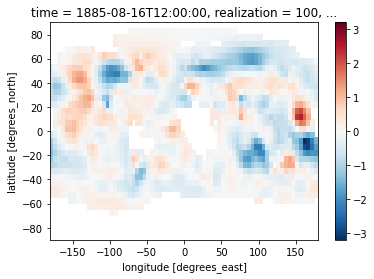

In [50]:
hadcrut5_glob.sel(time=K_dates[3]).plot()

In [59]:
# find where the anomalies are outside a threshold of +/- 2 standard deviations 
def stat_sig(dataset):
    """Find where the anomalies are outside a threshold of +/- 2 standard deviations.  Standard deviation calculated based on an 1850-1880 climatology.  
    
    Args:
        dataset (xarray): xarray of climate variable(s)
    """    
    import xarray as xr
    
    # calculate the standard deviation 
    if hasattr(dataset, 'time'):
        std = dataset.sel(time = slice('1850-01', '1881-01')).std(dim = ['time'])
    elif hasattr(dataset, 'seasonyear'):
        std = dataset.sel(seasonyear = slice('1850', '1881')).std(dim = ['seasonyear'])
    
    # mark points oustide the 2 standard deviation threshold with a 100 (and non significant points with a zero)
    sig = xr.where((dataset < - 2*std) | (dataset > 2*std), 100, 0)
    
    return sig 


#define a function for spatial plots, plotting a dataset at 4 different time intervals
def spatial_plot(rows, cols, dataset, cmax, times, titles, colours, units, std):
    """Create a figure of spatial graphs with subplots for each time snapshot as specified in the dataset and times array. 
    Can use stippling to show areas where anomaly exceeds 2 standard deviations. 
    
    Args:
        rows (int): number of rows of subplots
        cols (int): number of columns of subplots
        dataset (xarray): data array of climate variable to be plotted
        cmax (float): maximum magnitude for colourbar
        times (date_str): dictionary of dates (date_str) for each time to be plotted
        titles (date_str): dictionary of titles (str) for each subplot
        colours (dict): colour palette for cmap
        units (str): units for axes label
        std (int): if std==1: use stippling
    """
    import matplotlib.pyplot as plt, cartopy.crs as ccrs, numpy as np
    
    fig = plt.figure()
    axs = []

#     rows = 2
#     cols = 2
    # vmin = np.min(dataset)
    # vmax = np.max(dataset)
    
    # calculate the standard deviation (if desired, and input is 1)
    if std == 1:
        sig_dataset = stat_sig(dataset)
    
    # set discrete colourbar with 15 intervals
    cmap = plt.get_cmap(f'{colours}')#, 15)
    
    for i, d in enumerate(times):    
        # Add a subplot with a projection    
        ax = fig.add_subplot(rows, cols, i+1, projection=ccrs.PlateCarree(180))        
        # Select the date and corresponding data and plot it    
        # We'll add a separate colour bar, but make sure all plots share the same min and max colour value
        if hasattr(dataset, 'time'):
            data = dataset.sel(time = times[i])   
        if hasattr(dataset, 'seasonyear'):
            data = dataset.sel(seasonyear = times[i]) 
        
        C = data.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap = cmap, vmin=-cmax, vmax=cmax)
        # hatching where anomalies exceed a threshold of 2 standard deviations
        if std == 1:
            if hasattr(dataset, 'time'):
                data2 = sig_dataset.sel(time = times[i]).mean(dim='time')
                data2.plot.contourf(levels=[99, 1e10], hatches=[None,'..'], colors='none', add_colorbar=False, transform=ccrs.PlateCarree())
            elif hasattr(dataset, 'seasonyear'): # try this instead if the dataset is seasonal
                data2 = sig_dataset.sel(seasonyear = times[i])#.mean(dim='seasonyear')
                data2.plot.contourf(levels=[99, 1e10], hatches=[None,'..'], colors='none', add_colorbar=False, transform=ccrs.PlateCarree())
        
        # axes
        ax.coastlines()
#         # set the axis limits to be slihtly larger (2.5 degrees wither way) than the upper and lower bounds of the dataset 
#         if (len(data.lon) < int(175/1.5)) & (len(data.lat) < int(175/1.5)):
#             ax.set_extent([data.lon[0] - 2.5, data.lon[-1] + 2.5, data.lat[0] - 2.5, data.lat[-1] + 2.5], crs=ccrs.PlateCarree())
        # add on grid lines for longitude and latitude at specified range and spacing
        #ax.gridlines(xlocs=range(-180,181,20), ylocs=range(-80,81,20),draw_labels=False) 
        ax.gridlines(xlocs=range(-160,181,20), ylocs=range(-80,81,20),draw_labels=True)
        # add in different grid lines for tropics
        #tropics = ax.gridlines(ylocs=[-66.5,-23.43691,23.43691,66.5],draw_labels=False,linewidth=2,linestyle='--', edgecolor='dimgrey')
        #tropics.xlines=False
        # add titles for each subplot
        ax.set_title(titles[i])
        # Gather all axes for when we make the colour bar    
        axs.append(ax)    

    #Put the colour bar to the left of all axes
    cbar = plt.colorbar(C, orientation='horizontal', ax=axs, shrink=0.5, pad=0.05)
    cbar.ax.set_xlabel(f'{units}', fontsize=14)
    
    
    return fig

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


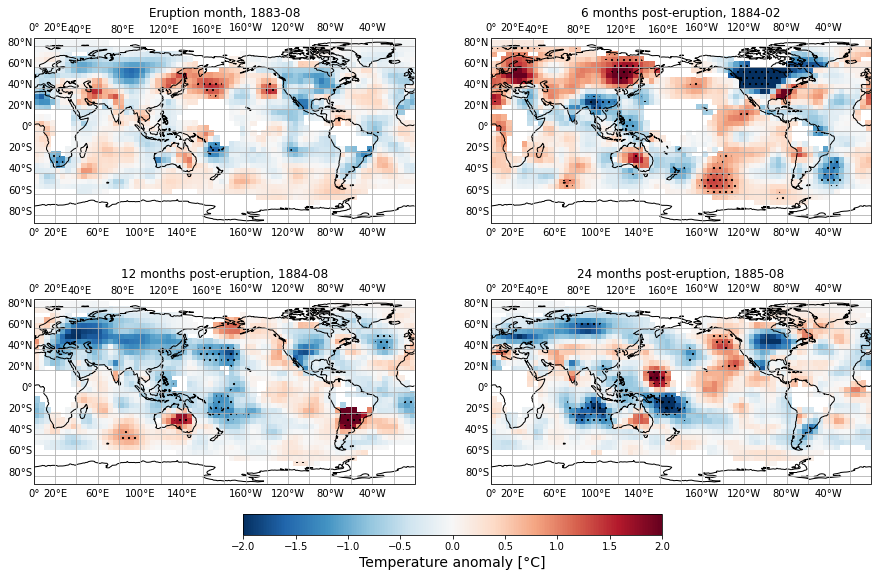

In [60]:
# plot of global monthly member mean temperature at 4 discrete time periods (not averaged)
fig = spatial_plot(2, 2, hadcrut5_glob, cmax_tmp, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('R_spatial_HadCRUT5_tmp_Glob.png', dpi=300)# , bbox_inches='tight') # bbox=tight removes lat labels when figure saves

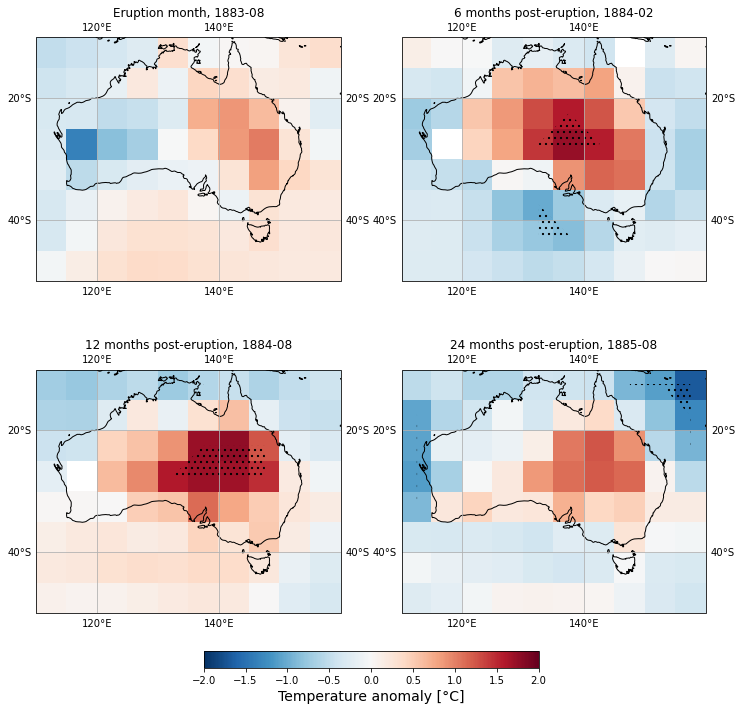

In [44]:
# plot of Aus monthly member mean temperature
fig = fplot.spatial_plot(2, 2, hadcrut5_Aus, cmax_tmp, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('R_spatial_HadCRUT5_tmp_Aus.png', dpi=300, bbox_inches='tight')

In [19]:
# # plot of global monthly member mean precipitation
# fig = fplot.spatial_plot(2, 2, K_mmm_mon_Glob.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 1)

# fig.set_figwidth(15)
# fig.set_figheight(11) # these two parameters change the figure height and width 

# plt.savefig('R_spatial_pr_Glob.png', dpi=300)#, bbox_inches='tight')

In [20]:
# # plot of Aus monthly member mean precipitation
# fig = fplot.spatial_plot(2, 2, K_mmm_mon_Aus.pr, cmax_pr, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 1)

# fig.set_figwidth(12)
# fig.set_figheight(14) # these two parameters change the figure height and width 

# plt.savefig('R_spatial_pr_Aus.png', dpi=300, bbox_inches='tight')